# DGA Detection
## Experiment 3: Building a DGA Classifier
<b><p id="intro" style="color: green">In this notebook we use the full dataset "dga_data_full.csv", apply the function for N-gram feature extraction and extract TLD feature from domain string.</p></b>
<a href="#WorkingOn">Go back</a>

In [235]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>

In [236]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_full.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [237]:
print(df.shape)
missing_values = df.isnull().sum()
print(missing_values)

(160000, 4)
isDGA       0
domain      2
host        0
subclass    0
dtype: int64


In [238]:
# Drop the rows with missing values
df = df.dropna()
print(df.shape)

(159998, 4)


In [239]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(duplicates)

0


In [240]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 80000
Legit: 79998


<b><h3>Part 2 - Feature Engineering</h3></b>

In [241]:
df.drop(['domain', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(159998, 2)


,isDGA,host
0,dga,6xzxsw3sokvg1tc752y1a6p0af.com
1,dga,glbtlxwwhbnpxs.ru
2,dga,xxmamopyipbfpk.ru
3,dga,zfd5szpi18i85wj9uy13l69rg.net
4,dga,jpqftymiuver.ru


In [242]:
# Change column name 'host' to 'root_domain_name'
df.rename(columns={'host':'domain_name'}, inplace=True)

In [243]:
# Transform IsDGA to binary values
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain_name
0,1,6xzxsw3sokvg1tc752y1a6p0af.com
1,1,glbtlxwwhbnpxs.ru
2,1,xxmamopyipbfpk.ru
3,1,zfd5szpi18i85wj9uy13l69rg.net
4,1,jpqftymiuver.ru


In [244]:
# Get 'domain_name' length and add as column 'domain_name_length'
df['domain_name_length'] = df['domain_name'].apply(lambda x: len(x))
df.head()

,isDGA,domain_name,domain_name_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30
1,1,glbtlxwwhbnpxs.ru,17
2,1,xxmamopyipbfpk.ru,17
3,1,zfd5szpi18i85wj9uy13l69rg.net,29
4,1,jpqftymiuver.ru,15


In [245]:
# Function to get the top level domain from 'host' and its length and add both as 2 new columns 'tld' and 'tld_length' 
def get_tld_length(domain):
    tld = domain.split('.')[-1]
    tld_length = len(tld)
    return tld, tld_length

df['tld'], df['tld_length'] = zip(*df['domain_name'].map(get_tld_length))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3
1,1,glbtlxwwhbnpxs.ru,17,ru,2
2,1,xxmamopyipbfpk.ru,17,ru,2
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3
4,1,jpqftymiuver.ru,15,ru,2


In [246]:
# Function to calculate number of digits 
def numDigits(domain):
    return sum(c.isdigit() for c in domain)

# Function to get the index of the first digit in a string
def firstDigitIndex(domain):
    for i, c in enumerate(domain):
        if c.isdigit():
            return i + 1
    return 0

In [247]:
df['digits'] = df['domain_name'].apply(lambda x: numDigits(x))
df['first_digit_idx'] = df['domain_name'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4
4,1,jpqftymiuver.ru,15,ru,2,0,0


In [248]:
# Calculate vowel to consonant ratio
def vowel_consonant_ratio(x):    
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [249]:
df['vowel_cons_ratio'] = df['domain_name'].apply(lambda x: vowel_consonant_ratio(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000


In [250]:
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
top_english_words.head()
d = top_english_words
# Save as pickle file
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

In [251]:
# Function to calculate Shannon Entropy
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

In [252]:
df['entropy'] = df['domain_name'].apply(lambda x: H_entropy(x))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio,entropy
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000,4.440224
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667,3.616875
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333,3.572469
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714,4.444188
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000,3.640224


In [254]:
with open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'rb') as f:
    d = load(f)

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
def ngrams(word, n):    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if ngram in d:
            count_sum+=d[ngram]
    
    try:
        feature = count_sum/(len(domain)-n+1)

    except:
        feature = 0
    
    return feature
    
def average_ngram_feature(l_ngram_feature):   
    return sum(l_ngram_feature)/len(l_ngram_feature)

In [255]:
dict_freq = { word[0]: num for num, word in enumerate(d.values, 1) }

In [256]:
df['ngrams'] = df['domain_name'].apply(lambda x: average_ngram_feature([ngram_feature(x, dict_freq, n) for n in [1,2,3]]))
df.head()

,isDGA,domain_name,domain_name_length,tld,tld_length,digits,first_digit_idx,vowel_cons_ratio,entropy,ngrams
0,1,6xzxsw3sokvg1tc752y1a6p0af.com,30,com,3,9,1,0.250000,4.440224,453.223536
1,1,glbtlxwwhbnpxs.ru,17,ru,2,0,0,0.066667,3.616875,1136.419118
2,1,xxmamopyipbfpk.ru,17,ru,2,0,0,0.333333,3.572469,1032.404412
3,1,zfd5szpi18i85wj9uy13l69rg.net,29,net,3,10,4,0.285714,4.444188,378.545947
4,1,jpqftymiuver.ru,15,ru,2,0,0,0.400000,3.640224,1402.937851


In [257]:
# Save the df as a new csv file named 'dga_features_pr3.csv'
df.to_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/processed/dga_features_pr3.csv', index=False)

<b><h3>Part 3 - Data Visualization</h3></b>

In [258]:
df_final = df.copy()

In [259]:
# Now we are going to apply data visualization to check distribution of data, correlation and so on
# first let's split data in features and target 
X = df_final.drop('isDGA', axis=1)
y = df_final['isDGA']

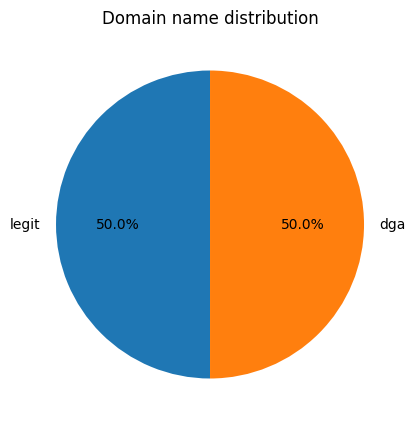

In [269]:
# Now let's visualize the features to see which will be of value and which will not be of value
# Plot isDGA distribution in a pie chart 
plt.figure(figsize=(5,5))
plt.pie(y.value_counts(), labels=['legit', 'dga'], autopct='%1.1f%%', startangle=90)
plt.title('Domain name distribution')
plt.show()

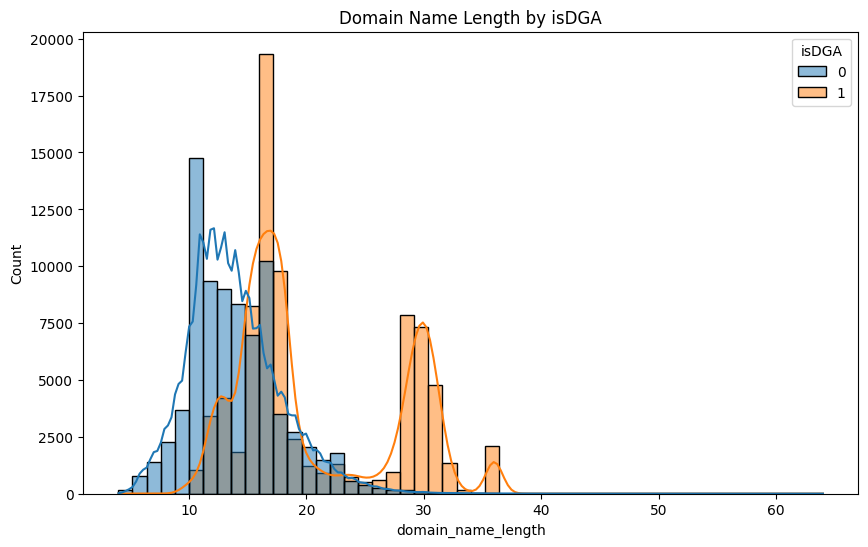

In [261]:
# Let's start with domain_name lenght by isDGA
plt.figure(figsize=(10, 6))
sns.histplot(data=df_final, x='domain_name_length', hue='isDGA', bins=50, kde=True) 
plt.title('Domain Name Length by isDGA')
plt.show()

In [267]:
# Get and show the most commong 'tld' associated with target 'isDGA' 
dga_tld = df[df['isDGA'] == 1]['tld'].value_counts()    
print(f"DGA common TLD: {dga_tld}")

DGA common TLD: tld
ru      36408
net     15757
org      7930
com      5808
biz      4353
uk       1201
info     1178
pw        224
mn        223
sc        220
ir        220
bit       217
cx        216
im        215
ug        214
ms        208
in        202
ki        201
cc        201
nf        198
cm        197
us        197
ac        196
co        196
eu        195
su        195
pro       195
tj        194
kz        192
sh        191
nu        190
so        190
jp        188
to        186
tv        184
xxx       182
sx        180
bz        180
tw        174
la        173
mx        171
mu        168
de        166
me        164
ga        162
Name: count, dtype: int64


C:\Users\Jorge Payà\AppData\Local\Temp\ipykernel_11580\283974488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dga_tld[:7].index, y=dga_tld[:7].values, palette='viridis')


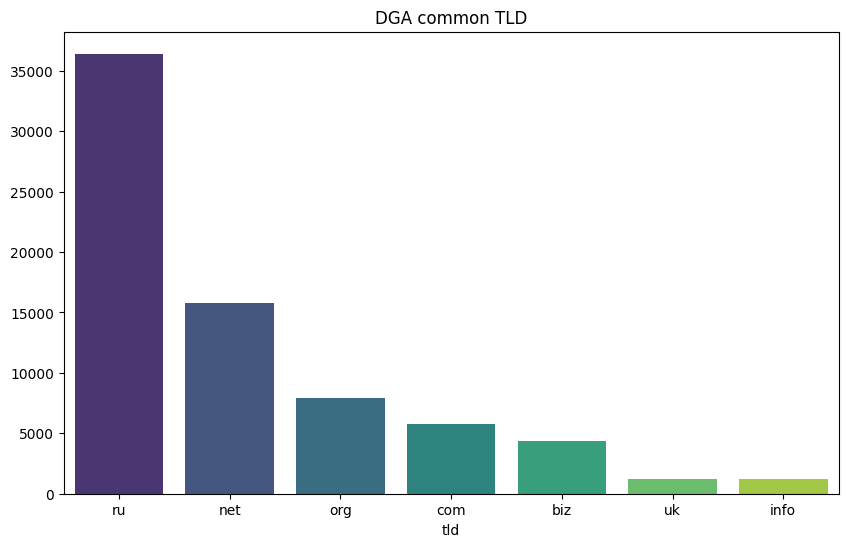

In [270]:
# Plot the 7 most common 'tld' associated with target 'isDGA'
plt.figure(figsize=(10, 6))
sns.barplot(x=dga_tld[:7].index, y=dga_tld[:7].values, palette='viridis')
plt.title('Most common TLD in DGA domains')
plt.show()

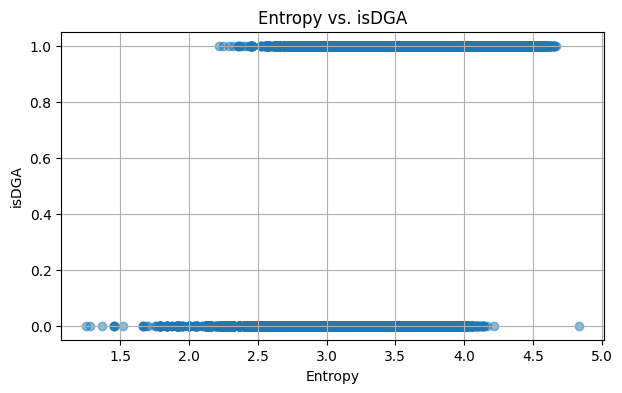

In [275]:
plt.figure(figsize=(7, 4))
plt.scatter(df_final['entropy'], df_final['isDGA'], alpha=0.5)
plt.xlabel('Entropy')
plt.ylabel('isDGA')
plt.title('Entropy vs. isDGA')
plt.grid(True)
plt.show()

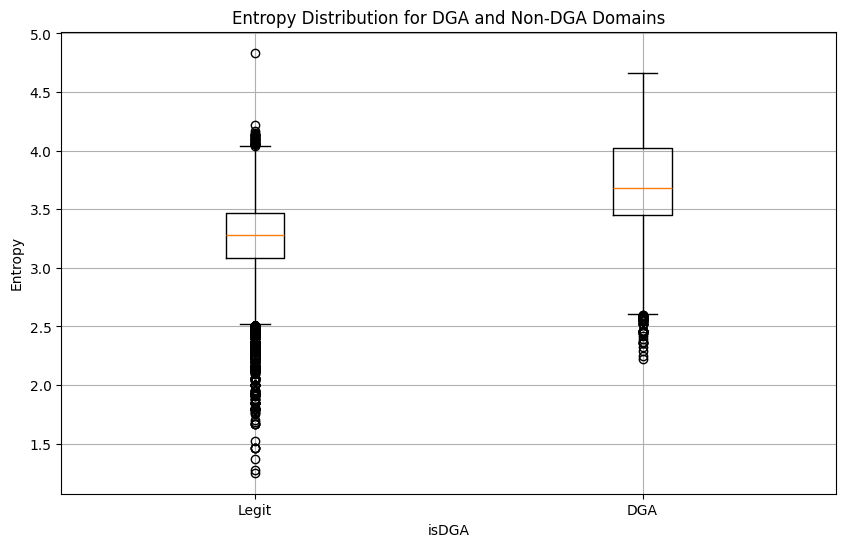

In [274]:
plt.figure(figsize=(10, 6))
plt.boxplot([df_final[df_final['isDGA'] == 0]['entropy'], df_final[df_final['isDGA'] == 1]['entropy']], labels=['Legit', 'DGA'])
plt.xlabel('isDGA')
plt.ylabel('Entropy')
plt.title('Entropy Distribution for DGA and Non-DGA Domains')
plt.grid(True)
plt.show()

In [ ]:
# The box plot shows that DGA domains have higher entropy than legit domains 

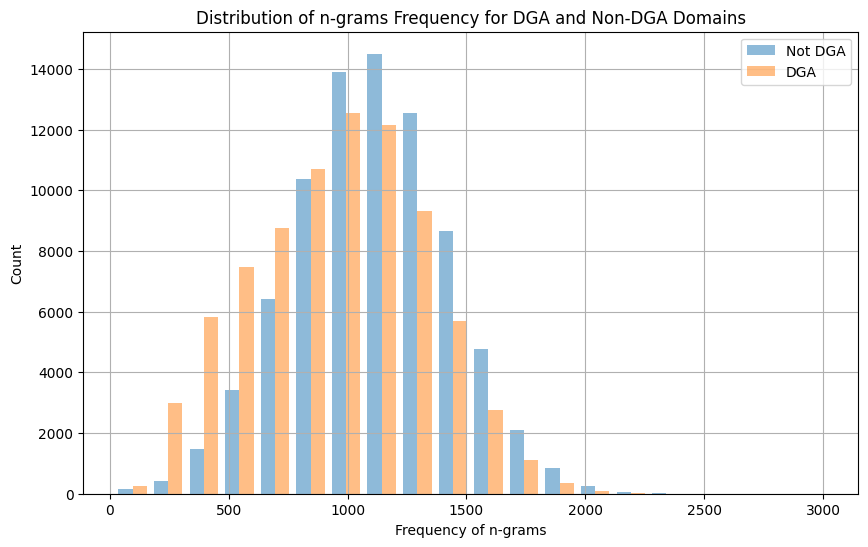

In [278]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist([df_final[df_final['isDGA'] == 0]['ngrams'], df_final[df_final['isDGA'] == 1]['ngrams']], bins=20, alpha=0.5, label=['Not DGA', 'DGA'])
plt.xlabel('Frequency of n-grams')
plt.ylabel('Count')
plt.title('Distribution of n-grams Frequency for DGA and Non-DGA Domains')
plt.legend()
plt.grid(True)
plt.show()

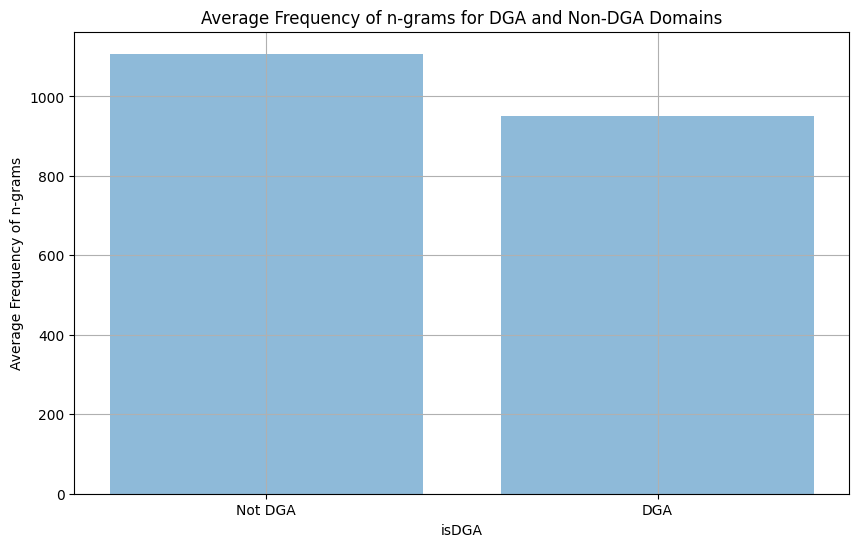

In [279]:
# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(['Not DGA', 'DGA'], [df_final[df_final['isDGA'] == 0]['ngrams'].mean(), df_final[df_final['isDGA'] == 1]['ngrams'].mean()], alpha=0.5)
plt.xlabel('isDGA')
plt.ylabel('Average Frequency of n-grams')
plt.title('Average Frequency of n-grams for DGA and Non-DGA Domains')
plt.grid(True)
plt.show()

<b><h3>Part 3 - Training the Decision Tree Classifier model</h3></b>

In [ ]:
df_final.drop(['domain_name', 'tld'], axis=1, inplace=True)
df_final.head()

In [62]:
# Split the data into features and target
# We are going to only use the most relevant features
X = df_final[['length', 'digits', 'entropy', 'vowel_cons', 'firstDigitIndex', 'ngrams']]
y = df_final['isDGA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
y_pred = dt_clf.predict(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 82.15%


In [97]:
# optimize the hyperparameters of the Decision Tree Classifier
dt_clf_opt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, min_samples_split=2, random_state=42)
dt_clf_opt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [98]:
y_pred = dt_clf_opt.predict(X_test)

In [99]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.95%


In [100]:
# Save the model
dump(dt_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_dt_clf_opt.pkl', 'wb'))

<b><h3>Part 4 - Training other classifiers</h3></b>
<h4 style="color: red">Random Forest Classifier</h4>

In [101]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred = rf_clf.predict(X_test)

In [103]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 83.59%


In [104]:
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'criterion': ['gini', 'entropy', 'log_loss'], 
                     'max_depth': [None, 5, 15, 20, 25], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5]} 

grid_rf = GridSearchCV(rf_clf, hyperparameters, cv=10) 
grid_rf

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150, 200]})

In [124]:
rf_clf_opt = RandomForestClassifier(n_estimators=100, 
                                    criterion='gini', 
                                    max_depth=15, 
                                    min_samples_leaf=5, 
                                    min_samples_split=20, 
                                    random_state=42)
rf_clf_opt.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [125]:
y_pred = rf_clf_opt.predict(X_test)

In [126]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 86.86%


In [127]:
# Save the model
dump(rf_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_rf_clf_opt.pkl', 'wb'))

<h4 style="color: red">K-NN Classifier</h4>

In [128]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [129]:
y_pred = knn_clf.predict(X_test)

In [130]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 77.74%


In [146]:
knn_clf_opt = KNeighborsClassifier(n_neighbors=7, 
                                   weights='distance', 
                                   leaf_size=10, 
                                   p=1, 
                                   algorithm='kd_tree')
knn_clf_opt.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=7, p=1,
                     weights='distance')

In [147]:
y_pred = knn_clf_opt.predict(X_test)

In [148]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 79.40%


In [149]:
# Save the model
dump(knn_clf_opt, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_pr3_knn_clf_opt.pkl', 'wb'))

<h4 style="color: red">Boosting Algorithms</h4>

In [150]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [151]:
y_pred = xgb_clf.predict(X_test)

In [152]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 87.03%


In [156]:
xgb_clf_opt = XGBClassifier(n_estimators=200, 
                            max_depth=7, 
                            learning_rate=0.1, 
                            subsample=0.7, 
                            colsample_bytree=0.7, 
                            gamma=50, 
                            random_state=42)

xgb_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=50, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [157]:
y_pred = xgb_clf_opt.predict(X_test)

In [158]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.91%


In [159]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [160]:
y_pred = gb_clf.predict(X_test)

In [161]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: %.2f%%" % (accuracy * 100.0))

Accuracy score: 85.83%


In [162]:
# optimize the hyperparameters of the Gradient Boosting Classifier using a Randomized Search
hyperparameters = {'n_estimators': [50, 100, 150, 200], 
                     'learning_rate': [0.01, 0.1, 0.5, 1], 
                     'subsample': [0.5, 0.7, 1.0], 
                     'max_depth': [3, 5, 7, 9], 
                     'min_samples_split': [2, 5, 10, 20], 
                     'min_samples_leaf': [1, 2, 4, 5], 
                     'max_features': ['auto', 'sqrt', 'log2']}

random_gb = RandomizedSearchCV(gb_clf, hyperparameters, cv=10, n_iter=100, random_state=42)
random_gb

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1],
                                        'max_depth': [3, 5, 7, 9],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 5],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42)

In [163]:
# Fit the model
random_gb.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters found: {random_gb.best_params_}")

KeyboardInterrupt: 

<a id="WorkingOn" href="#intro">Go up</a>